# Load dataset

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 60)
traffic = pd.read_csv("traffic_fines_1.csv", sep=';', low_memory=False)
display(traffic.head(3))
traffic.shape

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,expense,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,0.0,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,11.0,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,11.0,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant


(460556, 21)

In [324]:
a = pd.DateOffset(0)

In [329]:
a > pd.DateOffset(0)

TypeError: '>' not supported between instances of 'DateOffset' and 'DateOffset'

In [2]:
import EventLog as el

In [3]:
log = el.EventLog(traffic, 'Case ID', 'Complete Timestamp')

Found False


In [6]:
log.static_columns()

['article', 'vehicleClass', 'points', 'timesincemidnight', 'hour', 'label']

In [26]:
log.df.nunique()

article                   50
vehicleClass               4
amount                   204
points                     9
Case ID               129615
Activity                  10
Resource                 148
lastSent                   4
notificationType           3
dismissal                  8
expense                   84
Complete Timestamp      4903
timesincemidnight          1
month                     12
weekday                    7
hour                       1
timesincelastevent      1086
timesincecasestart      1360
event_nr                  20
open_cases             17274
label                      2
dtype: int64

# Preprocess and encode

In [33]:
from sklearn.preprocessing import OneHotEncoder
encoder = el.LogEncoder(transformers = [('static_drop', 'drop', []),
                                     ('static_keep', 'keep', ['amount', 'points']),
                                     ('static_onehot', el.WrapperEncoder(log.id_column,OneHotEncoder(sparse=False)), ['article', 'vehicleClass']),
                                     ('dynamic_drop', 'drop', []),
                                     ('dynamic_keep', 'keep', ['expense', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases']),
                                     ('dynamic_freq', el.FrequencyEncoder(log.id_column), ['Activity', 'Resource', 'lastSent','notificationType', 'dismissal'])])
#                                     ('timestamp', TimestampFeatures(log_1.id_column, ['event_order', 'time_from_start', 'remaining_time', 'elapsed_time_from_event']), [log_1.timestamp_column])])


encoder.check_unused(log)

['Case ID', 'Complete Timestamp', 'label']

In [172]:
X = encoder.fit_transform(log)

Fitting static_drop
Fitting static_keep
Fitting static_onehot
Fitting dynamic_drop
Fitting dynamic_keep
Fitting dynamic_freq
Transforming static_drop
Transforming static_keep
Transforming static_onehot
Transforming dynamic_drop
Transforming dynamic_keep
Transforming dynamic_freq


In [173]:
X.shape

(460556, 238)

In [37]:
(X.isnull().sum() > 0).sum()

0

# Descriptive analysis
We show some information concerning the distribution of the label (equally distributed), the categorical values and the events in each year (the number of events decreases with time and 2013 seems incomplete)

In [333]:
log.df.groupby(log.id_column)['label'].max().value_counts()

regular    70602
deviant    59013
Name: label, dtype: int64

In [335]:
log.df.groupby(log.df[log.timestamp_column].dt.year)['label'].value_counts()

Complete Timestamp  label  
2000                deviant    32622
                    regular    16845
2001                deviant    27288
                    regular    14547
2002                deviant    21861
                    regular    14304
2003                deviant    17997
                    regular    11037
2004                regular    16795
                    deviant    13396
2005                regular    25211
                    deviant    18422
2006                regular    27626
                    deviant    18531
2007                regular    18992
                    deviant    16393
2008                regular    17471
                    deviant    16706
2009                deviant    20440
                    regular    17236
2010                deviant    15476
                    regular    12364
2011                deviant    16932
                    regular    14746
2012                regular    11301
                    deviant     3414
2013      

In [343]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
for _, ts_i, _, ts in tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]):
    print(ts, y[ts_i].value_counts())



[2000-10-03 01:00:00, 2001-07-03 01:00:00] deviant    26475
regular    12970
Name: label, dtype: int64
[2001-07-03 01:00:00, 2002-04-03 01:00:00] deviant    25654
regular    10425
Name: label, dtype: int64
[2002-04-03 01:00:00, 2003-01-03 01:00:00] deviant    14245
regular    11661
Name: label, dtype: int64
[2003-01-03 01:00:00, 2003-10-03 01:00:00] deviant    11450
regular     8407
Name: label, dtype: int64
[2003-10-03 01:00:00, 2004-07-03 01:00:00] deviant    13356
regular     9006
Name: label, dtype: int64
[2004-07-03 01:00:00, 2005-04-03 01:00:00] deviant    13170
regular    11190
Name: label, dtype: int64
[2005-04-03 01:00:00, 2006-01-03 01:00:00] regular    19750
deviant    10156
Name: label, dtype: int64
[2006-01-03 01:00:00, 2006-10-03 01:00:00] regular    16906
deviant    13371
Name: label, dtype: int64
[2006-10-03 01:00:00, 2007-07-03 01:00:00] regular    19317
deviant    14899
Name: label, dtype: int64
[2007-07-03 01:00:00, 2008-04-03 01:00:00] regular    14092
deviant    13

[2008-04-03 01:00:00, 2009-01-03 01:00:00] regular    15738
deviant    11140
Name: label, dtype: int64
[2009-01-03 01:00:00, 2009-10-03 01:00:00] deviant    14836
regular    14255
Name: label, dtype: int64
[2009-10-03 01:00:00, 2010-07-03 01:00:00] deviant    14061
regular     7862
Name: label, dtype: int64
[2010-07-03 01:00:00, 2011-04-03 01:00:00] deviant    11653
regular     6512
Name: label, dtype: int64
[2011-04-03 01:00:00, 2012-01-03 01:00:00] regular    17431
deviant    13333
Name: label, dtype: int64
[2012-01-03 01:00:00, 2012-10-03 01:00:00] regular    11482
deviant     6872
Name: label, dtype: int64
[2012-10-03 01:00:00, 2013-07-03 01:00:00] regular    6830
deviant      15
Name: label, dtype: int64
[2005-04-03 01:00:00, 2006-01-03 01:00:00] regular    19750
deviant    10156
Name: label, dtype: int64
[2006-01-03 01:00:00, 2006-10-03 01:00:00] regular    16906
deviant    13371
Name: label, dtype: int64
[2006-10-03 01:00:00, 2007-07-03 01:00:00] regular    19317
deviant    1489

In [336]:
y = log.df['label']
y.value_counts()

deviant    239478
regular    221078
Name: label, dtype: int64

In [233]:
catcols = set(X.columns.values) - set(['amount', 'event_nr', 'expense', 'hour', 'month', 'open_cases', 'timesincecasestart', 'timesincelastevent', 'timesincemidnight', 'weekday'])

In [234]:
X.loc[:,catcols].max()

Resource_825.0                                9.0
Resource_816.0                                9.0
Resource_24.0                                 9.0
Activity_Notify Result Appeal to Offender     1.0
Resource_853.0                                6.0
x0_156.0                                      1.0
Resource_858.0                                9.0
Resource_54.0                                10.0
dismissal_D                                   6.0
notificationType_P                           18.0
Resource_556.0                                9.0
Resource_546.0                                9.0
Resource_828.0                                8.0
Resource_53.0                                 9.0
dismissal_#                                   4.0
x0_other                                      1.0
x0_167.0                                      1.0
Resource_704.0                               14.0
Resource_30.0                                14.0
Resource_851.0                                9.0


In [313]:
log.df[log.timestamp_column].dt.year.value_counts()

2000    49467
2006    46157
2005    43633
2001    41835
2009    37676
2002    36165
2007    35385
2008    34177
2011    31678
2004    30191
2003    29034
2010    27840
2012    14715
2013     2603
Name: Complete Timestamp, dtype: int64

# Experiments

## RQ1: Does the dataset changes over time?
To answer this question, we split the dataset into a set of intervals (e.g. each 9 months) and test whether the distribution of values of categorical attributes between the different intervals is statistically significant using chi2

[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2000-10-03 01:00:00, 2001-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2001-07-03 01:00:00, 2002-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",12090,7938
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2001-07-03 01:00:00, 2002-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",26475,12970
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",25654,10425
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",14245,11661
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",11450,8407
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",13356,9006
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",13170,11190
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",10156,19750
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",13371,16906
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",14899,19317
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",13877,14092
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,deviant,regular
i,,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255


[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",11140,15738
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,deviant,regular
i,,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862


[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",14836,14255
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,deviant,regular
i,,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512


[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",14061,7862
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2010-07-03 01:00:00, 2011-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,deviant,regular
i,,
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431


[2010-07-03 01:00:00, 2011-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2010-07-03 01:00:00, 2011-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",11653,6512
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2011-04-03 01:00:00, 2012-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,deviant,regular
i,,
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482


[2011-04-03 01:00:00, 2012-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",13333,17431
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


[2012-01-03 01:00:00, 2012-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,deviant,regular
i,,
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",6872,11482
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",15,6830


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

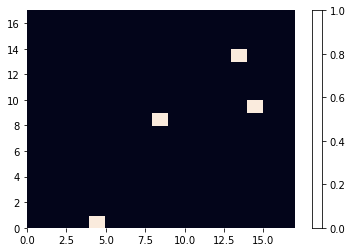

In [341]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
y_chi2 = compute_y_chi2(y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), verbose=True)
sns.heatmap(y_chi2.pivot(columns='test_interval', index='train_interval', values='pvalue').fillna(0) > 0.05)

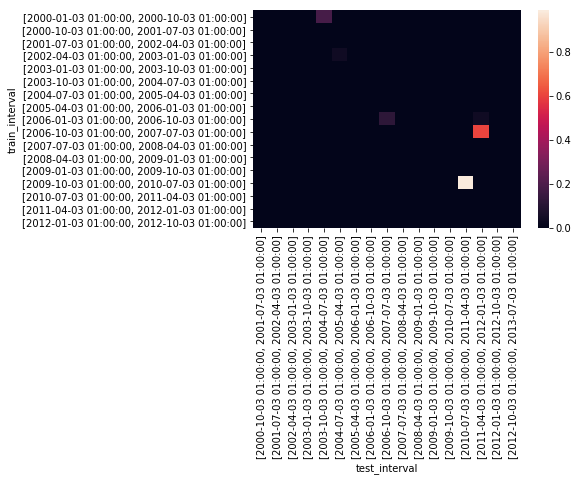

In [342]:
sns.heatmap(y_chi2.pivot(columns='test_interval', index='train_interval', values='pvalue').fillna(0))

In [269]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
allchi2 = compute_all_chi2(X.loc[:,catcols], tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]))

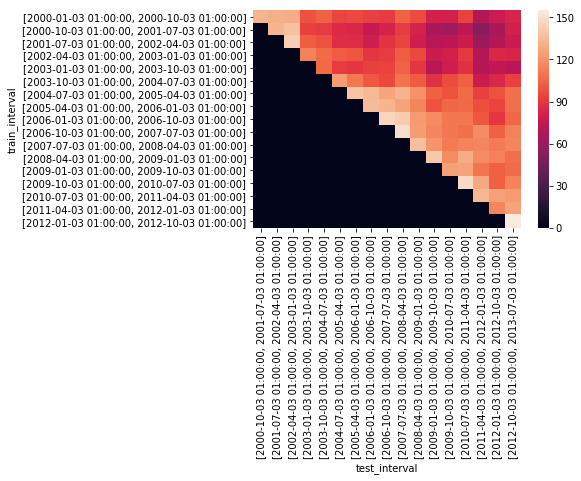

In [272]:
sns.heatmap(allchi2.pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))

The conclusion is that there is a difference between the first years of the dataset (until 2003) and the last years (before 2003). Furthermore, as expected, there are more similarities in the diagonal, which represent consecutive intervals.

We can look at one of the attributes in detail to see how can these results be interpreted. For instance, let's have a look to Resource 825

In [317]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
resource825_sum, resource825_detail = compute_all_chi2(X.loc[:,['Resource_825.0']], tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]),verbose=True)

[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2000-10-03 01:00:00, 2001-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2,0,0
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18


4.6051296314743665e-51
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2001-07-03 01:00:00, 2002-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2,0,0
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18


9.212817888622279e-61
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2,0,0,0,0,0
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1


6.058407486918514e-39
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2,0,0,0,0,0
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1


2.4409956098143775e-18
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2,0,0
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2


3.479943426752206e-26
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360,0,0,0,0


2.943009485225761e-33
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906,0,0,0,0


5.377217677363078e-41
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277,0,0,0,0


1.630759576835325e-41
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216,0,0,0,0


5.10125094254311e-47
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969,0,0,0,0


2.7224492814411693e-38
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878,0,0,0,0


9.066127698169114e-37
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091,0,0,0,0


7.390051591693909e-40
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923,0,0,0,0


7.301309363244289e-30
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165,0,0,0,0


1.226179366720389e-24
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764,0,0,0,0


3.405046244669744e-42
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354,0,0,0,0


6.700420829064745e-25
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00, 2000-10-03 01:00:00]",19898,63,63,2,2
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845,0,0,0,0


4.709460005260767e-09
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2001-07-03 01:00:00, 2002-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18


0.09407308087327249
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18,0,0,0
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1


0.013910397608163105
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18,0,0,0
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1


7.805835173644087e-31
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2


3.7938711471983135e-100
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360,0,0,0,0,0,0


3.2393957423737996e-116
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906,0,0,0,0,0,0


3.2737835736979136e-143
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277,0,0,0,0,0,0


5.11940265138468e-145
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216,0,0,0,0,0,0


3.444018909224347e-164
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969,0,0,0,0,0,0


8.779482094064996e-134
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878,0,0,0,0,0,0


1.7947550097012815e-128
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091,0,0,0,0,0,0


3.0343743223597537e-139
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923,0,0,0,0,0,0


2.3545829593112817e-104
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165,0,0,0,0,0,0


4.5597984145330835e-86
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764,0,0,0,0,0,0


2.1816174523417515e-147
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354,0,0,0,0,0,0


5.488281222684135e-87
[2000-10-03 01:00:00, 2001-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00, 2001-07-03 01:00:00]",38562,224,224,195,189,33,18
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845,0,0,0,0,0,0


3.7588000591914886e-31
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18,0,0,0
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1


0.0018078458888391156
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18,0,0,0
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1


1.5770065954256543e-41
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2


1.0856154687642602e-115
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360,0,0,0,0,0,0


2.682805071086919e-133
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906,0,0,0,0,0,0


3.7291159752081834e-164
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277,0,0,0,0,0,0


3.2195026456056607e-166
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216,0,0,0,0,0,0


3.9689795421717985e-188
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969,0,0,0,0,0,0


2.2264416956563797e-153
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878,0,0,0,0,0,0


2.6161549567651655e-147
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091,0,0,0,0,0,0


1.2749548753749469e-159
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923,0,0,0,0,0,0


9.780235726558881e-120
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165,0,0,0,0,0,0


8.028356428430254e-99
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764,0,0,0,0,0,0


6.291492165712699e-169
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354,0,0,0,0,0,0


7.125461991949384e-100
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00, 2002-04-03 01:00:00]",35157,250,250,197,179,28,18
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845,0,0,0,0,0,0


6.209758951614774e-36
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1


1.4082829104559982e-23
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2,0,0,0


1.2830807306167728e-88
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360,0,0,0,0,0,0,0,0,0


2.1153691649366067e-104
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906,0,0,0,0,0,0,0,0,0


3.1630926708890885e-129
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277,0,0,0,0,0,0,0,0,0


6.889965563038645e-131
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216,0,0,0,0,0,0,0,0,0


1.5355005172397637e-148
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969,0,0,0,0,0,0,0,0,0


1.4951726682419101e-120
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878,0,0,0,0,0,0,0,0,0


1.1449540926338928e-115
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091,0,0,0,0,0,0,0,0,0


1.4139713075958326e-125
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923,0,0,0,0,0,0,0,0,0


1.6607119944556649e-93
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165,0,0,0,0,0,0,0,0,0


9.923525920473802e-77
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764,0,0,0,0,0,0,0,0,0


4.5342720574324185e-133
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354,0,0,0,0,0,0,0,0,0


1.424999984667558e-77
[2002-04-03 01:00:00, 2003-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00, 2003-01-03 01:00:00]",25368,159,159,112,77,16,12,1,1,1
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845,0,0,0,0,0,0,0,0,0


1.1972854610176467e-26
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2003-10-03 01:00:00, 2004-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2,0,0,0


5.227859019085561e-30
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360,0,0,0,0,0,0,0,0,0


1.0917834784783238e-40
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906,0,0,0,0,0,0,0,0,0


7.922188027252792e-51
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277,0,0,0,0,0,0,0,0,0


1.6543572753881476e-51
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216,0,0,0,0,0,0,0,0,0


9.651075263271337e-59
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969,0,0,0,0,0,0,0,0,0


2.7966839372875447e-47
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878,0,0,0,0,0,0,0,0,0


2.7670277406971088e-45
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091,0,0,0,0,0,0,0,0,0


2.468062254777621e-49
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923,0,0,0,0,0,0,0,0,0


2.965755603443618e-36
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165,0,0,0,0,0,0,0,0,0


1.8791062327684986e-29
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764,0,0,0,0,0,0,0,0,0


2.1155014113034655e-52
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354,0,0,0,0,0,0,0,0,0


8.572759606185734e-30
[2003-01-03 01:00:00, 2003-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00, 2003-10-03 01:00:00]",19685,36,36,36,35,14,12,1,1,1
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845,0,0,0,0,0,0,0,0,0


1.5483438378155827e-09
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2004-07-03 01:00:00, 2005-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360,0,0,0,0,0,0


0.04185201491460089
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906,0,0,0,0,0,0


0.013477664713043371
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277,0,0,0,0,0,0


0.012467879014931248
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216,0,0,0,0,0,0


0.005381839473111041
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969,0,0,0,0,0,0


0.02016022979827663
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878,0,0,0,0,0,0


0.025214368396743677
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091,0,0,0,0,0,0


0.015979133516955044
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923,0,0,0,0,0,0


0.06735851890442751
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165,0,0,0,0,0,0


0.13555201852915802
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764,0,0,0,0,0,0


0.0112523812623628
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354,0,0,0,0,0,0


0.1310196453913484
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00, 2004-07-03 01:00:00]",22350,2,2,2,2,2,2
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845,0,0,0,0,0,0


0.720599264294999
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2005-04-03 01:00:00, 2006-01-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2004-07-03 01:00:00, 2005-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2004-07-03 01:00:00, 2005-04-03 01:00:00]",24360
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2006-01-03 01:00:00, 2006-10-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2005-04-03 01:00:00, 2006-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2005-04-03 01:00:00, 2006-01-03 01:00:00]",29906
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2006-10-03 01:00:00, 2007-07-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2006-01-03 01:00:00, 2006-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2006-01-03 01:00:00, 2006-10-03 01:00:00]",30277
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2007-07-03 01:00:00, 2008-04-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2006-10-03 01:00:00, 2007-07-03 01:00:00]",34216
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2007-07-03 01:00:00, 2008-04-03 01:00:00]",27969
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]


d,0
i,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091


1.0
[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2008-04-03 01:00:00, 2009-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2008-04-03 01:00:00, 2009-01-03 01:00:00]",26878
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]


d,0
i,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923


1.0
[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2009-01-03 01:00:00, 2009-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2009-01-03 01:00:00, 2009-10-03 01:00:00]",29091
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]


d,0
i,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165


1.0
[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2009-10-03 01:00:00, 2010-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2009-10-03 01:00:00, 2010-07-03 01:00:00]",21923
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2010-07-03 01:00:00, 2011-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]


d,0
i,
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764


1.0
[2010-07-03 01:00:00, 2011-04-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2010-07-03 01:00:00, 2011-04-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2010-07-03 01:00:00, 2011-04-03 01:00:00]",18165
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2011-04-03 01:00:00, 2012-01-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]


d,0
i,
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354


1.0
[2011-04-03 01:00:00, 2012-01-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2011-04-03 01:00:00, 2012-01-03 01:00:00]",30764
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0
[2012-01-03 01:00:00, 2012-10-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]


d,0
i,
"[2012-01-03 01:00:00, 2012-10-03 01:00:00]",18354
"[2012-10-03 01:00:00, 2013-07-03 01:00:00]",6845


1.0


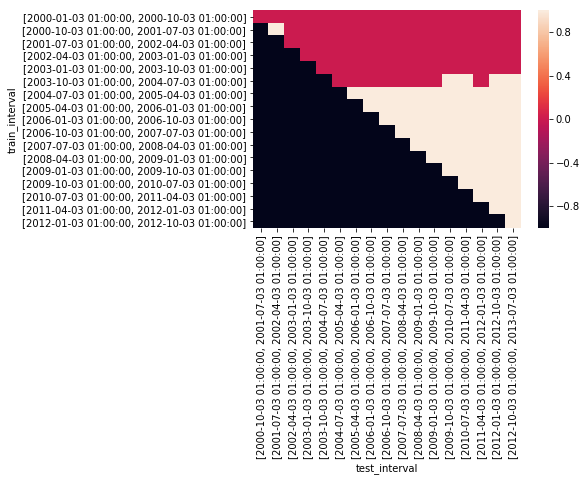

In [322]:
sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))

The conclusion is that there is no difference in the dataset since 2004. If we look into the details, we see that this resource stop appearing in the process in 2004. Actually, this coincides with the gap that we detected in the process in that year.

In [316]:
def compute_all_chi2(X, splits, verbose=False):
    summary = []
    detail = []
    for train_index, test_index, train_interval, test_interval in splits:
        pvalues = []
        for c in X.columns:
            data = pd.concat([pd.DataFrame({'d': X[c][train_index], 'i': str(train_interval)}),
                              pd.DataFrame({'d': X[c][test_index], 'i': str(test_interval)})], axis=0)

            contingency = pd.crosstab(data.i, data.d)                
            result = chi2_contingency(contingency)
            pvalues.append(result[1] > 0.05)
            if verbose:
                print(str(train_interval), str(test_interval))
                display(contingency)
                print(result[1])
            detail = np.append(detail, [train_interval, test_interval, c, result[1]], axis=0)

        count_pvalues = sum(pvalues)
        summary = np.append(summary, [train_interval, test_interval, count_pvalues], axis=0)

    return pd.DataFrame(np.reshape(summary, [-1,3]), columns=['train_interval', 'test_interval', 'num_of_h0']), pd.DataFrame(np.reshape(detail, [-1,4]), columns=['train_interval', 'test_interval', 'attrib', 'pvalue'])

In [263]:
import math
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import LabelEncoder

def compare_diag(summ1, summ2):
        diag1 = np.diag(shape_summary(summ1))
        diag2 = np.diag(shape_summary(summ2))
        
        diff = diag1[0:min(diag1.shape[0], diag2.shape[0])] - diag2[0:min(diag1.shape[0], diag2.shape[0])]
        return diff
        
        
def shape_summary(summary, values=['f1-score'], ncols=8):
    cols = ['precision', 'recall', 'f1-score', 'auc', 'train', 'test', 'train_size', 'test_size', 'label_size']
    
    return pd.DataFrame(np.reshape(summary, [-1,ncols]), columns=cols[:ncols]).pivot(columns='test', index='train', values=values)    

def run_experiment_classifier(X, y, splits, summary_class='True'):
    summary = []
    current_train_index = []

    for train_index, test_index, train_interval, test_interval in splits:
        print(test_index)
        X_test, Y_test = X.loc[test_index], y[test_index]

        if not np.array_equal(train_index, current_train_index):
            X_train, Y_train = X.loc[train_index], y[train_index]
            print("shapes: " + str((X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)))
            print(Y_train.value_counts())
            
            regressor = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
            regressor.fit(X_train, Y_train)
            current_train_index = train_index
            
        test_predict = regressor.predict(X_test)

        report = classification_report(Y_test, test_predict, output_dict = True)
        auc = roc_auc_score(Y_test, regressor.predict_proba(X_test)[:,regressor.classes_.tolist().index(summary_class)])


        print(train_interval, test_interval)
        print(Y_test.value_counts())
        #print("test set (precision / recall / f-score / auc): ", report['True']['precision'], report['True']['recall'], report['True']['f1-score'], auc)

        summary = np.append(summary, [report[summary_class]['precision'], report[summary_class]['recall'], report[summary_class]['f1-score'], auc, train_interval, test_interval, Y_train.shape[0], Y_test.shape[0]], axis=0)

    return summary  

def compute_weights(length):
    w = [math.exp(-x/3) for x in range(length,0,-1)]
    return [float(i)/sum(w) for i in w]

class VotingPretrained:
    def __init__(self, clf_list, weights):
        self.clf_list = clf_list
        self.weights = weights
        self.le_ = LabelEncoder()
        
    def fit(self, X, y):
        self.le_.fit(y)
        return
    
    def predict_proba(self, X):
        pred = np.asarray([clf.predict_proba(X) for clf in self.clf_list])
        predict_proba = np.average(pred, axis=0, weights=self.weights)
        return predict_proba

    def predict(self, X):
        return self.le_.inverse_transform(np.argmax(self.predict_proba(X), axis=1))

from scipy.stats import chi2_contingency
    
def compute_y_chi2(y, splits, verbose=False):
    summary = []
    
    for train_index, test_index, train_interval, test_interval in splits:
        data = pd.concat([pd.DataFrame({'d': y[train_index], 'i': str(train_interval)}),
                          pd.DataFrame({'d': y[test_index], 'i': str(test_interval)})], axis=0)
        
        contingency = pd.crosstab(data.i, data.d)
        if verbose:
            print(str(train_interval), str(test_interval))
            display(contingency)
        result = chi2_contingency(contingency)
        
        summary = np.append(summary, [train_interval, test_interval, result[0], result[1]], axis=0)

    return pd.DataFrame(np.reshape(summary, [-1,4]), columns=['train_interval', 'test_interval', 'chi2', 'pvalue'])



    
def run_experiment_classifier_voting(X, y, splits, summary_class='True', verbose=False):
    summary = []
    current_train_index = []
    regressors = []


    for train_index, test_index, train_interval, test_interval in splits:
        X_test, Y_test = X.loc[test_index], y[test_index]

        if not np.array_equal(train_index, current_train_index):
            X_train, Y_train = X.loc[train_index], y[train_index]
            if verbose:
                print("shapes: " + str((X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)))
                print(Y_train.value_counts())
            
            regressor = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
            regressor.fit(X_train, Y_train)
            current_train_index = train_index
            regressors.append(regressor)
            
            classifier = VotingPretrained(regressors, compute_weights(len(regressors)))
            classifier.fit(X_train, Y_train)
            #classifier = VotingClassifier(regressors, voting='soft', weights=compute_weights(len(regressors)))
            #classifier.fit(X_train, Y_train)

            
        test_predict = classifier.predict(X_test)

        report = classification_report(Y_test, test_predict, output_dict = True)
        auc = roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,regressor.classes_.tolist().index(summary_class)])

        if verbose:
            print(train_interval, test_interval)
            print(Y_test.value_counts())
        #print("test set (precision / recall / f-score / auc): ", report['True']['precision'], report['True']['recall'], report['True']['f1-score'], auc)

        summary = np.append(summary, [report[summary_class]['precision'], report[summary_class]['recall'], report[summary_class]['f1-score'], auc, train_interval, test_interval, Y_train.shape[0], Y_test.shape[0], Y_test.value_counts()[summary_class]], axis=0)

    return summary 

In [146]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
summary = run_experiment_classifier_voting(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), 'regular')
shape_summary(summary)




[ 64076  64077  64078 ... 455005 455006 455007]
shapes: ((20028, 238), (20028,), (39445, 238), (39445,))
deviant    12090
regular     7938
Name: label, dtype: int64
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2000-10-03 01:00:00, 2001-07-03 01:00:00]
deviant    26475
regular    12970
Name: label, dtype: int64
[ 64083  64084  64085 ... 457948 457949 457950]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2001-07-03 01:00:00, 2002-04-03 01:00:00]
deviant    25654
regular    10425
Name: label, dtype: int64
[ 64119  64120  64121 ... 460553 460554 460555]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]
deviant    14245
regular    11661
Name: label, dtype: int64
[ 64265  64266  64267 ... 460553 460554 460555]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]
deviant    11450
regular     8407
Name: label, dtype: int64
[ 64356  64357  64358 ... 460376 460377 460378]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-10-03 01:0

[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]
regular    15738
deviant    11140
Name: label, dtype: int64
[  1796   1797   1798 ... 446736 446737 446738]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]
deviant    14836
regular    14255
Name: label, dtype: int64
[  5885   5886   5887 ... 447026 447027 447028]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]
deviant    14061
regular     7862
Name: label, dtype: int64
[ 24835  24836  24837 ... 447212 447213 447214]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]
deviant    11653
regular     6512
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]
regular    17431
deviant    13333
Name: label, dtype: int64
[ 78068  78069  78070 ... 447759 447760 447761]
[2001-07-03 01:00:00, 2002-04-

[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]
deviant    14061
regular     7862
Name: label, dtype: int64
[ 24835  24836  24837 ... 447212 447213 447214]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]
deviant    11653
regular     6512
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]
regular    17431
deviant    13333
Name: label, dtype: int64
[ 78068  78069  78070 ... 447759 447760 447761]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]
regular    11482
deviant     6872
Name: label, dtype: int64
[ 80437  80438  80439 ... 447745 447746 447747]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]
regular    6830
deviant      15
Name: label, dtype: int64
[ 69833  69834  69835 ... 457295 457296 457297]
shapes: ((24360, 238), (24360,),

[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]
regular    17431
deviant    13333
Name: label, dtype: int64
[ 78068  78069  78070 ... 447759 447760 447761]
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]
regular    11482
deviant     6872
Name: label, dtype: int64
[ 80437  80438  80439 ... 447745 447746 447747]
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]
regular    6830
deviant      15
Name: label, dtype: int64
[     4      5      6 ... 445353 445354 445355]
shapes: ((27969, 238), (27969,), (26878, 238), (26878,))
regular    14092
deviant    13877
Name: label, dtype: int64
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]
regular    15738
deviant    11140
Name: label, dtype: int64
[  1796   1797   1798 ... 446736 446737 446738]
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]
deviant    14836
regula

ValueError: cannot reshape array of size 1377 into shape (8)

In [149]:
shape_summary(summary)

f1-score  \
test                                       [2000-10-03 01:00:00, 2001-07-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.570318   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                        NaN   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2002-04-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2003-10-03 01:00:00, 2004-07-03 01:00:00]                                        NaN   
[2004-07-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2005-04-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2006-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2006-10-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2007-07-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2008-04-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2009-01-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2009-10-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
[2010-07-03 01:00:00, 2011-04-03 01:00:00]                                        NaN   
[2011-04-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   
[2012-01-03 01:00:00, 2012-10-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2001-07-03 01:00:00, 2002-04-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.572275   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                   0.562258   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2002-04-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2003-10-03 01:00:00, 2004-07-03 01:00:00]                                        NaN   
[2004-07-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2005-04-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2006-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2006-10-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2007-07-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2008-04-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2009-01-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2009-10-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
[2010-07-03 01:00:00, 2011-04-03 01:00:00]                                        NaN   
[2011-04-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   
[2012-01-03 01:00:00, 2012-10-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2002-04-03 01:00:00, 2003-01-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                    0.71234   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                   0.708671   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                            

In [150]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=40, threshold=100, sliding=True)
summary_9_9_9 = run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), 'regular')
shape_summary(summary_9_9_9)



[ 64076  64077  64078 ... 455005 455006 455007]
shapes: ((20028, 238), (20028,), (39445, 238), (39445,))
deviant    12090
regular     7938
Name: label, dtype: int64
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2000-10-03 01:00:00, 2001-07-03 01:00:00]
deviant    26475
regular    12970
Name: label, dtype: int64
[ 64083  64084  64085 ... 457948 457949 457950]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2001-07-03 01:00:00, 2002-04-03 01:00:00]
deviant    25654
regular    10425
Name: label, dtype: int64
[ 64119  64120  64121 ... 460553 460554 460555]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2002-04-03 01:00:00, 2003-01-03 01:00:00]
deviant    14245
regular    11661
Name: label, dtype: int64
[ 64265  64266  64267 ... 460553 460554 460555]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-01-03 01:00:00, 2003-10-03 01:00:00]
deviant    11450
regular     8407
Name: label, dtype: int64
[ 64356  64357  64358 ... 460376 460377 460378]
[2000-01-03 01:00:00, 2000-10-03 01:00:00] [2003-10-03 01:0

[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]
regular    15738
deviant    11140
Name: label, dtype: int64
[  1796   1797   1798 ... 446736 446737 446738]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]
deviant    14836
regular    14255
Name: label, dtype: int64
[  5885   5886   5887 ... 447026 447027 447028]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]
deviant    14061
regular     7862
Name: label, dtype: int64
[ 24835  24836  24837 ... 447212 447213 447214]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]
deviant    11653
regular     6512
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2001-07-03 01:00:00, 2002-04-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]
regular    17431
deviant    13333
Name: label, dtype: int64
[ 78068  78069  78070 ... 447759 447760 447761]
[2001-07-03 01:00:00, 2002-04-

[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2009-10-03 01:00:00, 2010-07-03 01:00:00]
deviant    14061
regular     7862
Name: label, dtype: int64
[ 24835  24836  24837 ... 447212 447213 447214]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2010-07-03 01:00:00, 2011-04-03 01:00:00]
deviant    11653
regular     6512
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]
regular    17431
deviant    13333
Name: label, dtype: int64
[ 78068  78069  78070 ... 447759 447760 447761]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]
regular    11482
deviant     6872
Name: label, dtype: int64
[ 80437  80438  80439 ... 447745 447746 447747]
[2003-10-03 01:00:00, 2004-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]
regular    6830
deviant      15
Name: label, dtype: int64
[ 69833  69834  69835 ... 457295 457296 457297]
shapes: ((24360, 238), (24360,),

[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2011-04-03 01:00:00, 2012-01-03 01:00:00]
regular    17431
deviant    13333
Name: label, dtype: int64
[ 78068  78069  78070 ... 447759 447760 447761]
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-01-03 01:00:00, 2012-10-03 01:00:00]
regular    11482
deviant     6872
Name: label, dtype: int64
[ 80437  80438  80439 ... 447745 447746 447747]
[2006-10-03 01:00:00, 2007-07-03 01:00:00] [2012-10-03 01:00:00, 2013-07-03 01:00:00]
regular    6830
deviant      15
Name: label, dtype: int64
[     4      5      6 ... 445353 445354 445355]
shapes: ((27969, 238), (27969,), (26878, 238), (26878,))
regular    14092
deviant    13877
Name: label, dtype: int64
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2008-04-03 01:00:00, 2009-01-03 01:00:00]
regular    15738
deviant    11140
Name: label, dtype: int64
[  1796   1797   1798 ... 446736 446737 446738]
[2007-07-03 01:00:00, 2008-04-03 01:00:00] [2009-01-03 01:00:00, 2009-10-03 01:00:00]
deviant    14836
regula

f1-score  \
test                                       [2000-10-03 01:00:00, 2001-07-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.570318   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
20028                                                                             NaN   
19857                                                                             NaN   
0.6136881660814391                                                                NaN   
0.7652658227848101                                                                NaN   
0.7647503994169914                                                                NaN   
0.6672216885198562                                                                NaN   
[2008-04-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
21923                                                                             NaN   
0.7215357724067265                                                                NaN   
0.7217383731057307                                                                NaN   
0.7320103857566765                                                                NaN   
0.7686678598183276                                                           0.852374   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
39445                                                                             NaN   
24360                                                                             NaN   
0.7146356748134222                                                                NaN   
0.6631982191851736                                                                NaN   
0.713724178305595                                                                 NaN   
0.7004637285414004                                                           0.693989   
[2009-10-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
30764                                                                             NaN   
0.9978171896316508                                                                NaN   
0.7051710830975045                                                                NaN   
0.5683556626952853                                                                NaN   
0.6552477585240335                                                                NaN   
[2005-04-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
36079                                                                             NaN   
...                                                                               ...   
29091                                                                             NaN   
0.45605105832929393                                                               NaN   
0.8357523951580518                                                                NaN   
0.7435350473410426                                                                NaN   
0.6664128843338213                                                                NaN   
[2006-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
30277                                                                             NaN   
0.4315352697095436                                                                NaN   
0.8035683552291893                                                                NaN   
0.8102160752949493                                                                NaN   
0.751966813079551                                                                 NaN   
[2006-10-03 01:00:00, 2007-07-03 01:00:00]                              

In [257]:
shape_summary(summary_9_9_9, ncols=8)

f1-score  \
test                                       [2000-10-03 01:00:00, 2001-07-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.570318   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                        NaN   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2002-04-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2003-10-03 01:00:00, 2004-07-03 01:00:00]                                        NaN   
[2004-07-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2005-04-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2006-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2006-10-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2007-07-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2008-04-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2009-01-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2009-10-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
[2010-07-03 01:00:00, 2011-04-03 01:00:00]                                        NaN   
[2011-04-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   
[2012-01-03 01:00:00, 2012-10-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2001-07-03 01:00:00, 2002-04-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.572275   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                   0.569761   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2002-04-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2003-10-03 01:00:00, 2004-07-03 01:00:00]                                        NaN   
[2004-07-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2005-04-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2006-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2006-10-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2007-07-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2008-04-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2009-01-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2009-10-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
[2010-07-03 01:00:00, 2011-04-03 01:00:00]                                        NaN   
[2011-04-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   
[2012-01-03 01:00:00, 2012-10-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2002-04-03 01:00:00, 2003-01-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                    0.71234   
[2000-10-03 01:00:00, 2001-07-03 01:00:00]                                   0.662128   
[2001-07-03 01:00:00, 2002-04-03 01:00:00]                            

In [ ]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=40, threshold=100, sliding=False)
summary_3 = run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), 'regular')
shape_summary(summary_3)




summary_9_9_9_F = summary_3

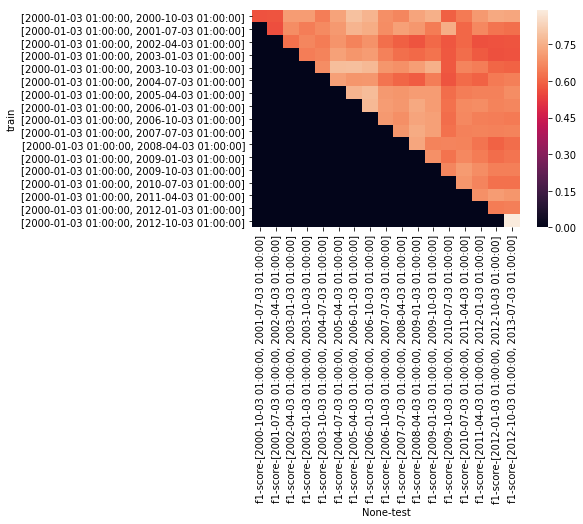

In [266]:
import seaborn as sns
ax = sns.heatmap(shape_summary(summary_9_9_9_F, ncols=8).fillna(0))

In [268]:
ax = sns.heatmap(shape_summary(summary_9_9_9, ncols=8).fillna(0))

NameError: name 'summary_300' is not defined

In [264]:
compare_diag(summary_9_9_9, summary_9_9_9_F)

array([0.0, 0.008885878008407566, 0.00951458702129726,
       0.024901133192617442, -0.037384088268438864, -0.09810912139063221,
       -0.000970625313089557, -0.0557747006146353, -0.0314863721346994,
       -0.10796214419009764, -0.05357555085867283, -0.030460714888536855,
       -0.06048013932870011, -0.1574685560864596, 0.05433354768934462,
       0.09939071061790783, 0.06670259093830233], dtype=object)

In [256]:
shape_summary(summary_9_9_9_F, ncols=8)

f1-score  \
test                                       [2000-10-03 01:00:00, 2001-07-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.570318   
[2000-01-03 01:00:00, 2001-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2004-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2011-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2012-10-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2001-07-03 01:00:00, 2002-04-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                   0.572275   
[2000-01-03 01:00:00, 2001-07-03 01:00:00]                                   0.560876   
[2000-01-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2004-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2010-07-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2011-04-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   
[2000-01-03 01:00:00, 2012-10-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2002-04-03 01:00:00, 2003-01-03 01:00:00]   
train                                                                                   
[2000-01-03 01:00:00, 2000-10-03 01:00:00]                                    0.71234   
[2000-01-03 01:00:00, 2001-07-03 01:00:00]                                   0.680758   
[2000-01-03 01:00:00, 2002-04-03 01:00:00]                            

In [88]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=3), train_freq=pd.DateOffset(months=3), test_freq=pd.DateOffset(months=3), test_periods=30, threshold=2000, sliding=True)
summary_2 = run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), 'regular')
shape_summary(summary_2)

summary_3_3_3 = summary_2

[ 64097  64098  64099 ... 452370 452371 452372]
shapes: ((6619, 238), (6619,), (12337, 238), (12337,))
deviant    4690
regular    1929
Name: label, dtype: int64
[2000-04-03 01:00:00, 2000-07-03 01:00:00] [2000-07-03 01:00:00, 2000-10-03 01:00:00]
deviant    7407
regular    4930
Name: label, dtype: int64
[ 64078  64079  64080 ... 453911 453912 453913]
[2000-04-03 01:00:00, 2000-07-03 01:00:00] [2000-10-03 01:00:00, 2001-01-03 01:00:00]
deviant    14397
regular     5253
Name: label, dtype: int64
[ 64091  64092  64093 ... 454578 454579 454580]
[2000-04-03 01:00:00, 2000-07-03 01:00:00] [2001-01-03 01:00:00, 2001-04-03 01:00:00]
deviant    8739
regular    3970
Name: label, dtype: int64
[ 64291  64292  64293 ... 455537 455538 455539]
[2000-04-03 01:00:00, 2000-07-03 01:00:00] [2001-07-03 01:00:00, 2001-10-03 01:00:00]
deviant    7252
regular    4725
Name: label, dtype: int64
[ 64083  64084  64085 ... 457948 457949 457950]
[2000-04-03 01:00:00, 2000-07-03 01:00:00] [2002-01-03 01:00:00, 2002

[2000-07-03 01:00:00, 2000-10-03 01:00:00] [2007-04-03 01:00:00, 2007-07-03 01:00:00]
regular    5363
deviant    1734
Name: label, dtype: int64
[     9     10     11 ... 443868 443869 443870]
[2000-07-03 01:00:00, 2000-10-03 01:00:00] [2007-07-03 01:00:00, 2007-10-03 01:00:00]
regular    4118
deviant    2263
Name: label, dtype: int64
[    27     28     29 ... 443915 443916 443917]
[2000-07-03 01:00:00, 2000-10-03 01:00:00] [2007-10-03 01:00:00, 2008-01-03 01:00:00]
regular    7395
deviant    6007
Name: label, dtype: int64
[   475    476    477 ... 444124 444125 444126]
[2000-07-03 01:00:00, 2000-10-03 01:00:00] [2008-01-03 01:00:00, 2008-04-03 01:00:00]
deviant    5663
regular    2631
Name: label, dtype: int64
[ 64091  64092  64093 ... 454578 454579 454580]
shapes: ((19650, 238), (19650,), (12709, 238), (12709,))
deviant    14397
regular     5253
Name: label, dtype: int64
[2000-10-03 01:00:00, 2001-01-03 01:00:00] [2001-01-03 01:00:00, 2001-04-03 01:00:00]
deviant    8739
regular    39

[2001-01-03 01:00:00, 2001-04-03 01:00:00] [2007-01-03 01:00:00, 2007-04-03 01:00:00]
deviant    8578
regular    5349
Name: label, dtype: int64
[    82     83    124 ... 443876 443877 443878]
[2001-01-03 01:00:00, 2001-04-03 01:00:00] [2007-04-03 01:00:00, 2007-07-03 01:00:00]
regular    5363
deviant    1734
Name: label, dtype: int64
[     9     10     11 ... 443868 443869 443870]
[2001-01-03 01:00:00, 2001-04-03 01:00:00] [2007-07-03 01:00:00, 2007-10-03 01:00:00]
regular    4118
deviant    2263
Name: label, dtype: int64
[    27     28     29 ... 443915 443916 443917]
[2001-01-03 01:00:00, 2001-04-03 01:00:00] [2007-10-03 01:00:00, 2008-01-03 01:00:00]
regular    7395
deviant    6007
Name: label, dtype: int64
[   475    476    477 ... 444124 444125 444126]
[2001-01-03 01:00:00, 2001-04-03 01:00:00] [2008-01-03 01:00:00, 2008-04-03 01:00:00]
deviant    5663
regular    2631
Name: label, dtype: int64
[     4      5      6 ... 444793 444794 444795]
[2001-01-03 01:00:00, 2001-04-03 01:00:0

[2002-01-03 01:00:00, 2002-04-03 01:00:00] [2006-10-03 01:00:00, 2007-01-03 01:00:00]
regular    8698
deviant    4655
Name: label, dtype: int64
[     0      1      2 ... 443752 443753 443754]
[2002-01-03 01:00:00, 2002-04-03 01:00:00] [2007-01-03 01:00:00, 2007-04-03 01:00:00]
deviant    8578
regular    5349
Name: label, dtype: int64
[    82     83    124 ... 443876 443877 443878]
[2002-01-03 01:00:00, 2002-04-03 01:00:00] [2007-04-03 01:00:00, 2007-07-03 01:00:00]
regular    5363
deviant    1734
Name: label, dtype: int64
[     9     10     11 ... 443868 443869 443870]
[2002-01-03 01:00:00, 2002-04-03 01:00:00] [2007-07-03 01:00:00, 2007-10-03 01:00:00]
regular    4118
deviant    2263
Name: label, dtype: int64
[    27     28     29 ... 443915 443916 443917]
[2002-01-03 01:00:00, 2002-04-03 01:00:00] [2007-10-03 01:00:00, 2008-01-03 01:00:00]
regular    7395
deviant    6007
Name: label, dtype: int64
[   475    476    477 ... 444124 444125 444126]
[2002-01-03 01:00:00, 2002-04-03 01:00:0

[2002-10-03 01:00:00, 2003-01-03 01:00:00] [2005-10-03 01:00:00, 2006-01-03 01:00:00]
regular    8330
deviant    4135
Name: label, dtype: int64
[ 64271  64272  68797 ... 442310 442311 442312]
[2002-10-03 01:00:00, 2003-01-03 01:00:00] [2006-01-03 01:00:00, 2006-04-03 01:00:00]
deviant    7223
regular    5852
Name: label, dtype: int64
[ 71364  71365  71366 ... 442742 442743 442744]
[2002-10-03 01:00:00, 2003-01-03 01:00:00] [2006-04-03 01:00:00, 2006-07-03 01:00:00]
regular    6100
deviant    4329
Name: label, dtype: int64
[   126    127   1161 ... 442774 442775 442776]
[2002-10-03 01:00:00, 2003-01-03 01:00:00] [2006-07-03 01:00:00, 2006-10-03 01:00:00]
regular    5136
deviant    1844
Name: label, dtype: int64
[  2849   2850   2851 ... 442898 442899 442900]
[2002-10-03 01:00:00, 2003-01-03 01:00:00] [2006-10-03 01:00:00, 2007-01-03 01:00:00]
regular    8698
deviant    4655
Name: label, dtype: int64
[     0      1      2 ... 443752 443753 443754]
[2002-10-03 01:00:00, 2003-01-03 01:00:0

[2003-07-03 01:00:00, 2003-10-03 01:00:00] [2005-04-03 01:00:00, 2005-07-03 01:00:00]
regular    5759
deviant    2723
Name: label, dtype: int64
[ 70027  70028  70029 ... 456086 456087 456088]
[2003-07-03 01:00:00, 2003-10-03 01:00:00] [2005-07-03 01:00:00, 2005-10-03 01:00:00]
regular    5740
deviant    3535
Name: label, dtype: int64
[ 69833  69834  69835 ... 455243 455244 455245]
[2003-07-03 01:00:00, 2003-10-03 01:00:00] [2005-10-03 01:00:00, 2006-01-03 01:00:00]
regular    8330
deviant    4135
Name: label, dtype: int64
[ 64271  64272  68797 ... 442310 442311 442312]
[2003-07-03 01:00:00, 2003-10-03 01:00:00] [2006-01-03 01:00:00, 2006-04-03 01:00:00]
deviant    7223
regular    5852
Name: label, dtype: int64
[ 71364  71365  71366 ... 442742 442743 442744]
[2003-07-03 01:00:00, 2003-10-03 01:00:00] [2006-04-03 01:00:00, 2006-07-03 01:00:00]
regular    6100
deviant    4329
Name: label, dtype: int64
[   126    127   1161 ... 442774 442775 442776]
[2003-07-03 01:00:00, 2003-10-03 01:00:0

[2004-07-03 01:00:00, 2004-10-03 01:00:00] [2005-01-03 01:00:00, 2005-04-03 01:00:00]
deviant    10376
regular     4138
Name: label, dtype: int64
[ 70566  70567  70568 ... 457295 457296 457297]
[2004-07-03 01:00:00, 2004-10-03 01:00:00] [2005-04-03 01:00:00, 2005-07-03 01:00:00]
regular    5759
deviant    2723
Name: label, dtype: int64
[ 70027  70028  70029 ... 456086 456087 456088]
[2004-07-03 01:00:00, 2004-10-03 01:00:00] [2005-07-03 01:00:00, 2005-10-03 01:00:00]
regular    5740
deviant    3535
Name: label, dtype: int64
[ 69833  69834  69835 ... 455243 455244 455245]
[2004-07-03 01:00:00, 2004-10-03 01:00:00] [2005-10-03 01:00:00, 2006-01-03 01:00:00]
regular    8330
deviant    4135
Name: label, dtype: int64
[ 64271  64272  68797 ... 442310 442311 442312]
[2004-07-03 01:00:00, 2004-10-03 01:00:00] [2006-01-03 01:00:00, 2006-04-03 01:00:00]
deviant    7223
regular    5852
Name: label, dtype: int64
[ 71364  71365  71366 ... 442742 442743 442744]
[2004-07-03 01:00:00, 2004-10-03 01:00

[2005-01-03 01:00:00, 2005-04-03 01:00:00] [2011-07-03 01:00:00, 2011-10-03 01:00:00]
regular    9359
deviant    3735
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2005-01-03 01:00:00, 2005-04-03 01:00:00] [2011-10-03 01:00:00, 2012-01-03 01:00:00]
deviant    7351
regular    5767
Name: label, dtype: int64
[ 79026  79027  79028 ... 447697 447698 447699]
[2005-01-03 01:00:00, 2005-04-03 01:00:00] [2012-07-03 01:00:00, 2012-10-03 01:00:00]
regular    7018
deviant      55
Name: label, dtype: int64
[ 70027  70028  70029 ... 456086 456087 456088]
shapes: ((8482, 238), (8482,), (9275, 238), (9275,))
regular    5759
deviant    2723
Name: label, dtype: int64
[2005-04-03 01:00:00, 2005-07-03 01:00:00] [2005-07-03 01:00:00, 2005-10-03 01:00:00]
regular    5740
deviant    3535
Name: label, dtype: int64
[ 69833  69834  69835 ... 455243 455244 455245]
[2005-04-03 01:00:00, 2005-07-03 01:00:00] [2005-10-03 01:00:00, 2006-01-03 01:00:00]
regular    8330
deviant    4135
Nam

[2005-07-03 01:00:00, 2005-10-03 01:00:00] [2010-10-03 01:00:00, 2011-01-03 01:00:00]
deviant    7305
regular    1856
Name: label, dtype: int64
[ 23955  23956  23957 ... 447443 447444 447445]
[2005-07-03 01:00:00, 2005-10-03 01:00:00] [2011-07-03 01:00:00, 2011-10-03 01:00:00]
regular    9359
deviant    3735
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2005-07-03 01:00:00, 2005-10-03 01:00:00] [2011-10-03 01:00:00, 2012-01-03 01:00:00]
deviant    7351
regular    5767
Name: label, dtype: int64
[ 79026  79027  79028 ... 447697 447698 447699]
[2005-07-03 01:00:00, 2005-10-03 01:00:00] [2012-07-03 01:00:00, 2012-10-03 01:00:00]
regular    7018
deviant      55
Name: label, dtype: int64
[ 64271  64272  68797 ... 442310 442311 442312]
shapes: ((12465, 238), (12465,), (13075, 238), (13075,))
regular    8330
deviant    4135
Name: label, dtype: int64
[2005-10-03 01:00:00, 2006-01-03 01:00:00] [2006-01-03 01:00:00, 2006-04-03 01:00:00]
deviant    7223
regular    5852

[2006-01-03 01:00:00, 2006-04-03 01:00:00] [2012-07-03 01:00:00, 2012-10-03 01:00:00]
regular    7018
deviant      55
Name: label, dtype: int64
[   126    127   1161 ... 442774 442775 442776]
shapes: ((10429, 238), (10429,), (6980, 238), (6980,))
regular    6100
deviant    4329
Name: label, dtype: int64
[2006-04-03 01:00:00, 2006-07-03 01:00:00] [2006-07-03 01:00:00, 2006-10-03 01:00:00]
regular    5136
deviant    1844
Name: label, dtype: int64
[  2849   2850   2851 ... 442898 442899 442900]
[2006-04-03 01:00:00, 2006-07-03 01:00:00] [2006-10-03 01:00:00, 2007-01-03 01:00:00]
regular    8698
deviant    4655
Name: label, dtype: int64
[     0      1      2 ... 443752 443753 443754]
[2006-04-03 01:00:00, 2006-07-03 01:00:00] [2007-01-03 01:00:00, 2007-04-03 01:00:00]
deviant    8578
regular    5349
Name: label, dtype: int64
[    82     83    124 ... 443876 443877 443878]
[2006-04-03 01:00:00, 2006-07-03 01:00:00] [2007-04-03 01:00:00, 2007-07-03 01:00:00]
regular    5363
deviant    1734
N

[2006-10-03 01:00:00, 2007-01-03 01:00:00] [2008-07-03 01:00:00, 2008-10-03 01:00:00]
regular    6999
deviant    2692
Name: label, dtype: int64
[   101    102    103 ... 445353 445354 445355]
[2006-10-03 01:00:00, 2007-01-03 01:00:00] [2008-10-03 01:00:00, 2009-01-03 01:00:00]
regular    6030
deviant    5178
Name: label, dtype: int64
[  1796   1797   1798 ... 445671 445672 445673]
[2006-10-03 01:00:00, 2007-01-03 01:00:00] [2009-01-03 01:00:00, 2009-04-03 01:00:00]
deviant    6397
regular    3407
Name: label, dtype: int64
[  8913   8914   8915 ... 445876 445877 445878]
[2006-10-03 01:00:00, 2007-01-03 01:00:00] [2009-04-03 01:00:00, 2009-07-03 01:00:00]
regular    3717
deviant    2134
Name: label, dtype: int64
[  3161   3162   3163 ... 446736 446737 446738]
[2006-10-03 01:00:00, 2007-01-03 01:00:00] [2009-07-03 01:00:00, 2009-10-03 01:00:00]
regular    7258
deviant    6381
Name: label, dtype: int64
[  6793   6794   6795 ... 447026 447027 447028]
[2006-10-03 01:00:00, 2007-01-03 01:00:0

[2007-07-03 01:00:00, 2007-10-03 01:00:00] [2008-01-03 01:00:00, 2008-04-03 01:00:00]
deviant    5663
regular    2631
Name: label, dtype: int64
[     4      5      6 ... 444793 444794 444795]
[2007-07-03 01:00:00, 2007-10-03 01:00:00] [2008-07-03 01:00:00, 2008-10-03 01:00:00]
regular    6999
deviant    2692
Name: label, dtype: int64
[   101    102    103 ... 445353 445354 445355]
[2007-07-03 01:00:00, 2007-10-03 01:00:00] [2008-10-03 01:00:00, 2009-01-03 01:00:00]
regular    6030
deviant    5178
Name: label, dtype: int64
[  1796   1797   1798 ... 445671 445672 445673]
[2007-07-03 01:00:00, 2007-10-03 01:00:00] [2009-01-03 01:00:00, 2009-04-03 01:00:00]
deviant    6397
regular    3407
Name: label, dtype: int64
[  8913   8914   8915 ... 445876 445877 445878]
[2007-07-03 01:00:00, 2007-10-03 01:00:00] [2009-04-03 01:00:00, 2009-07-03 01:00:00]
regular    3717
deviant    2134
Name: label, dtype: int64
[  3161   3162   3163 ... 446736 446737 446738]
[2007-07-03 01:00:00, 2007-10-03 01:00:0

[2008-07-03 01:00:00, 2008-10-03 01:00:00] [2010-10-03 01:00:00, 2011-01-03 01:00:00]
deviant    7305
regular    1856
Name: label, dtype: int64
[ 23955  23956  23957 ... 447443 447444 447445]
[2008-07-03 01:00:00, 2008-10-03 01:00:00] [2011-07-03 01:00:00, 2011-10-03 01:00:00]
regular    9359
deviant    3735
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2008-07-03 01:00:00, 2008-10-03 01:00:00] [2011-10-03 01:00:00, 2012-01-03 01:00:00]
deviant    7351
regular    5767
Name: label, dtype: int64
[ 79026  79027  79028 ... 447697 447698 447699]
[2008-07-03 01:00:00, 2008-10-03 01:00:00] [2012-07-03 01:00:00, 2012-10-03 01:00:00]
regular    7018
deviant      55
Name: label, dtype: int64
[  1796   1797   1798 ... 445671 445672 445673]
shapes: ((11208, 238), (11208,), (9804, 238), (9804,))
regular    6030
deviant    5178
Name: label, dtype: int64
[2008-10-03 01:00:00, 2009-01-03 01:00:00] [2009-01-03 01:00:00, 2009-04-03 01:00:00]
deviant    6397
regular    3407
N

[2010-07-03 01:00:00, 2010-10-03 01:00:00] [2011-07-03 01:00:00, 2011-10-03 01:00:00]
regular    9359
deviant    3735
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2010-07-03 01:00:00, 2010-10-03 01:00:00] [2011-10-03 01:00:00, 2012-01-03 01:00:00]
deviant    7351
regular    5767
Name: label, dtype: int64
[ 79026  79027  79028 ... 447697 447698 447699]
[2010-07-03 01:00:00, 2010-10-03 01:00:00] [2012-07-03 01:00:00, 2012-10-03 01:00:00]
regular    7018
deviant      55
Name: label, dtype: int64
[ 23955  23956  23957 ... 447443 447444 447445]
shapes: ((9161, 238), (9161,), (13094, 238), (13094,))
deviant    7305
regular    1856
Name: label, dtype: int64
[2010-10-03 01:00:00, 2011-01-03 01:00:00] [2011-07-03 01:00:00, 2011-10-03 01:00:00]
regular    9359
deviant    3735
Name: label, dtype: int64
[   907    908    909 ... 455462 455463 455464]
[2010-10-03 01:00:00, 2011-01-03 01:00:00] [2011-10-03 01:00:00, 2012-01-03 01:00:00]
deviant    7351
regular    5767
N

f1-score  \
test                                       [2000-07-03 01:00:00, 2000-10-03 01:00:00]   
train                                                                                   
[2000-04-03 01:00:00, 2000-07-03 01:00:00]                                    0.66421   
[2000-07-03 01:00:00, 2000-10-03 01:00:00]                                        NaN   
[2000-10-03 01:00:00, 2001-01-03 01:00:00]                                        NaN   
[2001-01-03 01:00:00, 2001-04-03 01:00:00]                                        NaN   
[2001-07-03 01:00:00, 2001-10-03 01:00:00]                                        NaN   
[2002-01-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2002-07-03 01:00:00, 2002-10-03 01:00:00]                                        NaN   
[2002-10-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-04-03 01:00:00]                                        NaN   
[2003-07-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2004-01-03 01:00:00, 2004-04-03 01:00:00]                                        NaN   
[2004-07-03 01:00:00, 2004-10-03 01:00:00]                                        NaN   
[2005-01-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2005-04-03 01:00:00, 2005-07-03 01:00:00]                                        NaN   
[2005-07-03 01:00:00, 2005-10-03 01:00:00]                                        NaN   
[2005-10-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2006-01-03 01:00:00, 2006-04-03 01:00:00]                                        NaN   
[2006-04-03 01:00:00, 2006-07-03 01:00:00]                                        NaN   
[2006-07-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2006-10-03 01:00:00, 2007-01-03 01:00:00]                                        NaN   
[2007-01-03 01:00:00, 2007-04-03 01:00:00]                                        NaN   
[2007-04-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2007-07-03 01:00:00, 2007-10-03 01:00:00]                                        NaN   
[2007-10-03 01:00:00, 2008-01-03 01:00:00]                                        NaN   
[2008-01-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2008-07-03 01:00:00, 2008-10-03 01:00:00]                                        NaN   
[2008-10-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2009-01-03 01:00:00, 2009-04-03 01:00:00]                                        NaN   
[2009-04-03 01:00:00, 2009-07-03 01:00:00]                                        NaN   
[2009-07-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2010-01-03 01:00:00, 2010-04-03 01:00:00]                                        NaN   
[2010-07-03 01:00:00, 2010-10-03 01:00:00]                                        NaN   
[2010-10-03 01:00:00, 2011-01-03 01:00:00]                                        NaN   
[2011-07-03 01:00:00, 2011-10-03 01:00:00]                                        NaN   
[2011-10-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2000-10-03 01:00:00, 2001-01-03 01:00:00]   
train                                                                                   
[2000-04-03 01:00:00, 2000-07-03 01:00:00]                                   0.426662   
[2000-07-03 01:00:00, 2000-10-03 01:00:00]                                   0.500437   
[2000-10-03 01:00:00, 2001-01-03 01:00:00]                                        NaN   
[2001-01-03 01:00:00, 2001-04-03 01:00:00]                                        NaN   
[2001-07-03 01:00:00, 2001-10-03 01:00:00]                             

In [255]:
shape_summary(summary_3_3_3, ncols=8)

f1-score  \
test                                       [2000-07-03 01:00:00, 2000-10-03 01:00:00]   
train                                                                                   
[2000-04-03 01:00:00, 2000-07-03 01:00:00]                                    0.66421   
[2000-07-03 01:00:00, 2000-10-03 01:00:00]                                        NaN   
[2000-10-03 01:00:00, 2001-01-03 01:00:00]                                        NaN   
[2001-01-03 01:00:00, 2001-04-03 01:00:00]                                        NaN   
[2001-07-03 01:00:00, 2001-10-03 01:00:00]                                        NaN   
[2002-01-03 01:00:00, 2002-04-03 01:00:00]                                        NaN   
[2002-07-03 01:00:00, 2002-10-03 01:00:00]                                        NaN   
[2002-10-03 01:00:00, 2003-01-03 01:00:00]                                        NaN   
[2003-01-03 01:00:00, 2003-04-03 01:00:00]                                        NaN   
[2003-07-03 01:00:00, 2003-10-03 01:00:00]                                        NaN   
[2004-01-03 01:00:00, 2004-04-03 01:00:00]                                        NaN   
[2004-07-03 01:00:00, 2004-10-03 01:00:00]                                        NaN   
[2005-01-03 01:00:00, 2005-04-03 01:00:00]                                        NaN   
[2005-04-03 01:00:00, 2005-07-03 01:00:00]                                        NaN   
[2005-07-03 01:00:00, 2005-10-03 01:00:00]                                        NaN   
[2005-10-03 01:00:00, 2006-01-03 01:00:00]                                        NaN   
[2006-01-03 01:00:00, 2006-04-03 01:00:00]                                        NaN   
[2006-04-03 01:00:00, 2006-07-03 01:00:00]                                        NaN   
[2006-07-03 01:00:00, 2006-10-03 01:00:00]                                        NaN   
[2006-10-03 01:00:00, 2007-01-03 01:00:00]                                        NaN   
[2007-01-03 01:00:00, 2007-04-03 01:00:00]                                        NaN   
[2007-04-03 01:00:00, 2007-07-03 01:00:00]                                        NaN   
[2007-07-03 01:00:00, 2007-10-03 01:00:00]                                        NaN   
[2007-10-03 01:00:00, 2008-01-03 01:00:00]                                        NaN   
[2008-01-03 01:00:00, 2008-04-03 01:00:00]                                        NaN   
[2008-07-03 01:00:00, 2008-10-03 01:00:00]                                        NaN   
[2008-10-03 01:00:00, 2009-01-03 01:00:00]                                        NaN   
[2009-01-03 01:00:00, 2009-04-03 01:00:00]                                        NaN   
[2009-04-03 01:00:00, 2009-07-03 01:00:00]                                        NaN   
[2009-07-03 01:00:00, 2009-10-03 01:00:00]                                        NaN   
[2010-01-03 01:00:00, 2010-04-03 01:00:00]                                        NaN   
[2010-07-03 01:00:00, 2010-10-03 01:00:00]                                        NaN   
[2010-10-03 01:00:00, 2011-01-03 01:00:00]                                        NaN   
[2011-07-03 01:00:00, 2011-10-03 01:00:00]                                        NaN   
[2011-10-03 01:00:00, 2012-01-03 01:00:00]                                        NaN   

                                                                                       \
test                                       [2000-10-03 01:00:00, 2001-01-03 01:00:00]   
train                                                                                   
[2000-04-03 01:00:00, 2000-07-03 01:00:00]                                   0.426662   
[2000-07-03 01:00:00, 2000-10-03 01:00:00]                                   0.500437   
[2000-10-03 01:00:00, 2001-01-03 01:00:00]                                        NaN   
[2001-01-03 01:00:00, 2001-04-03 01:00:00]                                        NaN   
[2001-07-03 01:00:00, 2001-10-03 01:00:00]                             